# Contents
- 1. Modeling Objective
- 2. Data Loading
- 3. Feature Setup (same as final OLS)
- 4. Train/Test Split
- 5. Baseline OLS Regression (statsmodels)
- 6. Ridge Regression
- 7. RandomForest
- 8. Performance Comparison
- 9. Feature Importance (RandomForest)
- 10. Prediction Visualization
- 11. Conclusion (Extension)

# 1. Modeling Objective

# Model Extension (Ridge / RandomForest)

본 노트북은 02_modeling.ipynb에서 구축한 OLS 모델을 baseline으로 두고,
Ridge(규제 선형)와 RandomForest(비선형 트리) 모델을 추가하여 예측 성능(R², RMSE)을 비교한다.

해석(계수/가정검증)은 02_modeling.ipynb에서 수행했으며, 본 노트북에서는 “예측 관점의 확장 가능성”을 확인하는 것을 목표로 한다.

# 2. Data Loading


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import mysql.connector

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../data/processed/feature_anime.csv")
df.shape, df.head()

((9999, 16),
    anime_id                            title  score  members   type  episodes  \
 0         1                     Cowboy Bebop   8.75  2014470     TV        26   
 1         5  Cowboy Bebop: Tengoku no Tobira   8.38   404634  Movie         1   
 2         6                           Trigun   8.22   817570     TV        26   
 3         7               Witch Hunter Robin   7.23   126303     TV        26   
 4         8                   Bouken Ou Beet   6.92    16486     TV        52   
 
    start_date  popularity  genre_count  company_count  studio_count  \
 0  1998-01-01          42            5              4             1   
 1  2001-01-01         650            4              3             1   
 2  1998-01-01         265            4              3             1   
 3  2002-01-01        1982            4              4             1   
 4  2004-01-01        5773            4              3             1   
 
    producer_count  voice_actor_count  japanese_va_count  y

# 3. Feature Setup (same as final OLS)


In [7]:
df_model = pd.get_dummies(df, columns = ["type"], drop_first = True, dtype = int)

features = [
    "score",
    "genre_count",
    "producer_count",
    "studio_count",
    "voice_actor_count",
    "year",
] + [c for c in df_model.columns if c.startswith("type_")]

# 02_modeling에서 제거했던 비유의 변수 동일하게 제외
if "type_TV Special" in features:
    features.remove("type_TV Special")

X = df_model[features]
y = df_model["log_members"]

X.shape, y.shape

((9999, 10), (9999,))

# 4. Train/Test Split


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape

((7999, 10), (2000, 10))

# 5. Baseline OLS Regression (statsmodels)


In [9]:
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_const).fit()
ols_pred = ols_model.predict(X_test_const)

ols_r2 = r2_score(y_test, ols_pred)
ols_rmse = mean_squared_error(y_test, ols_pred, squared = False)

print("OLS Test R2:", round(ols_r2, 4))
print("OLS Test RMSE:", round(ols_rmse, 4))

OLS Test R2: 0.598
OLS Test RMSE: 1.2233


해석:
- OLS 모델은 테스트 데이터에서 약 60%의 분산을 설명한다.
- Train R²(≈0.616)와 큰 차이가 없으므로 심각한 과적합은 발생하지 않았다.
- 선형 가정 하에서 비교적 안정적인 예측력을 보인다.
- 그러나 약 40%의 설명되지 않는 분산이 존재한다.

→ 선형 모델만으로는 인기 형성을 완전히 설명하기 어렵다.

# 6. Ridge Regression


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(random_state = 42))])

param_grid = {"ridge__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]}

ridge_grid = GridSearchCV(ridge_pipe, param_grid = param_grid, cv = 5, scoring = "r2", n_jobs = -1)

ridge_grid.fit(X_train, y_train)

ridge_best = ridge_grid.best_estimator_
ridge_pred = ridge_best.predict(X_test)

ridge_r2 = r2_score(y_test, ridge_pred)
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared = False)

print("Best alpha:", ridge_grid.best_params_["ridge__alpha"])
print("Ridge Test R2:", round(ridge_r2, 4))
print("Ridge Test RMSE:", round(ridge_rmse, 4))

Best alpha: 10.0
Ridge Test R2: 0.5981
Ridge Test RMSE: 1.2232


해석:
- OLS 모델은 테스트 데이터에서 약 60%의 분산을 설명한다.
- Train R²(≈0.616)와 큰 차이가 없으므로 심각한 과적합은 발생하지 않았다.
- 선형 가정 하에서 비교적 안정적인 예측력을 보인다.
- 그러나 약 40%의 설명되지 않는 분산이 존재한다.

→ 선형 모델만으로는 인기 형성을 완전히 설명하기 어렵다.

# 7. RandomForest


In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 400, random_state = 42, n_jobs = -1, min_samples_leaf = 2)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = mean_squared_error(y_test, rf_pred, squared = False)

print("RF Test R2:", round(rf_r2, 4))
print("RF Test RMSE:", round(rf_rmse, 4))

RF Test R2: 0.7164
RF Test RMSE: 1.0274


해석:
- 설명력이 약 +0.12 (12%) 상승했다.
- 오차(RMSE)가 유의미하게 감소했다. 이는 변수들과 인기 사이에 비선형 관계가 존재할 가능성을 의미한다.
- OLS가 포착하지 못한 상호작용 또는 임계값 효과를 RandomForest가 학습했을 가능성이 높다.
- 예시 가능한 구조: 일정 점수 이상에서 인기 급증 / 제작 규모와 평점의 상호작용 / 연도에 따른 효과 차등

→ 인기 형성 구조는 완전히 선형적이지 않다.

# 8. Performance Comparison


In [12]:
results_df = pd.DataFrame({"Model": ["OLS (statsmodels)",
                          f"Ridge (alpha={ridge_grid.best_params_['ridge__alpha']})", "RandomForest"],
                           "Test_R2": [ols_r2, ridge_r2, rf_r2],"Test_RMSE": [ols_rmse, ridge_rmse, rf_rmse],
                          }).sort_values("Test_R2", ascending = False)

results_df

,Model,Test_R2,Test_RMSE
2,RandomForest,0.716425,1.027448
1,Ridge (alpha=10.0),0.598064,1.223219
0,OLS (statsmodels),0.598043,1.223252


In [13]:
results_df.style.format({"Test_R2":"{:.3f}", "Test_RMSE":"{:.3f}"})

,Model,Test_R2,Test_RMSE
2,RandomForest,0.716,1.027
1,Ridge (alpha=10.0),0.598,1.223
0,OLS (statsmodels),0.598,1.223


- OLS
    - 해석 가능
    - 계수 기반 인과적 설명에 유리
    - 예측 성능은 중간 수준

- Ridge
    - 과적합 제어 목적
    - 본 데이터에서는 개선 효과 미미

- RandomForest
    - 비선형 구조 반영 가능
    - 가장 높은 예측 성능
    - 해석은 상대적으로 제한적 (계수 X)

### Performance Summary

- OLS와 Ridge는 유사한 성능을 보였으며, 본 데이터에서는 강한 규제가 필요하지 않았다.
- RandomForest는 Test R²를 약 12% 개선하며 비선형 구조의 존재 가능성을 시사하였다.

# 9. Feature Importance (RandomForest)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature importance 추출
importances = rf.feature_importances_
feature_names = X_train.columns

fi_df = pd.DataFrame({"feature": feature_names, "importance": importances
                     }).sort_values(by = "importance", ascending = False)

fi_df.head(10)

,feature,importance
0,score,0.374823
2,producer_count,0.239825
4,voice_actor_count,0.142022
5,year,0.119992
1,genre_count,0.054767
9,type_TV,0.046863
3,studio_count,0.006348
8,type_Special,0.005631
7,type_OVA,0.005189
6,type_ONA,0.004540


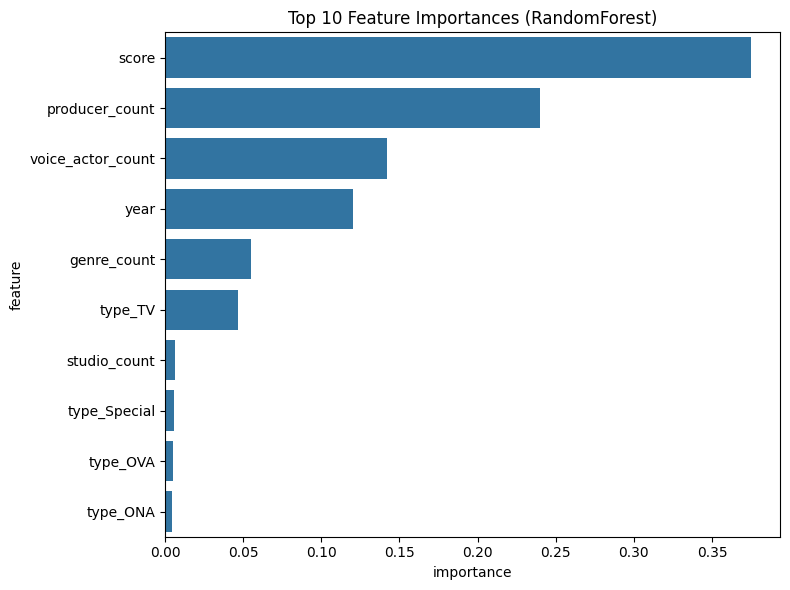

In [15]:
plt.figure(figsize = (8, 6))
sns.barplot(data = fi_df.head(10), x = "importance", y = "feature")
plt.title("Top 10 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

## OLS vs RandomForest 비교 해석

- 두 모델 모두 score와 producer_count를 핵심 변수로 식별하였다.
- 이는 작품의 평가 수준과 제작 규모가 인기 형성에 구조적으로 중요한 요인임을 시사한다.
- 그러나 RandomForest에서는 voice_actor_count의 중요도가 상대적으로 높게 나타났으며, 이는 비선형 또는 상호작용 효과의 존재 가능성을 보여준다.
- 따라서 인기 형성 구조는 완전한 선형 관계라기보다는 일부 비선형적 특성을 포함하는 복합적 구조일 가능성이 있다.

# 10. Prediction Visualization

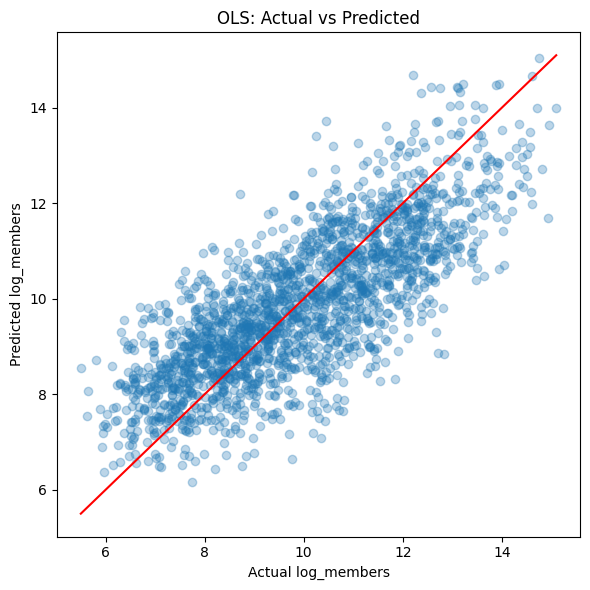

In [ ]:
plt.figure(figsize = (6, 6))
plt.scatter(y_test, ols_pred, alpha = 0.3)
plt.xlabel("Actual log_members")
plt.ylabel("Predicted log_members")
plt.title("OLS: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = "red")
plt.tight_layout()
plt.show()

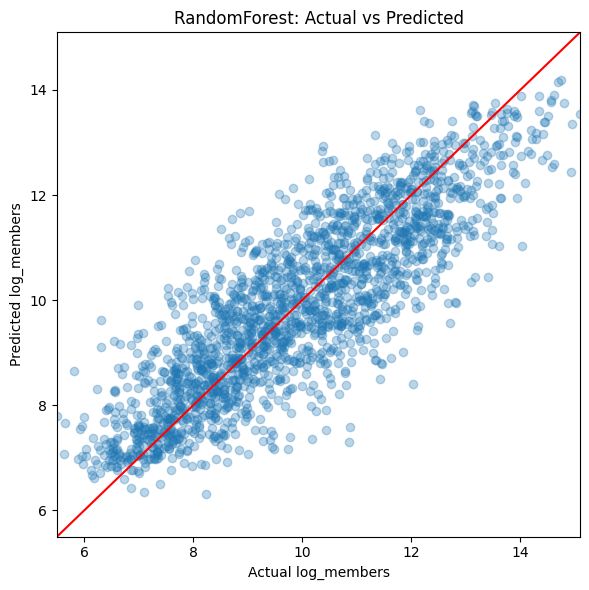

In [20]:
plt.figure(figsize = (6, 6))
plt.scatter(y_test, rf_pred, alpha = 0.3)
plt.xlabel("Actual log_members")
plt.ylabel("Predicted log_members")
plt.title("RandomForest: Actual vs Predicted")

min_val = min(y_test.min(), rf_pred.min())
max_val = max(y_test.max(), rf_pred.max())

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = "red")
plt.tight_layout()
plt.show()

해석: 
- RandomForest 모델은 실제값과 예측값이 대각선에 더 밀집되어 있으며, 특히 중간 인기 구간에서 예측 정확도가 향상되었다.
- 반면 OLS는 전반적으로 유사한 추세를 보이나 분산이 더 크게 나타났다.
- 이는 RandomForest가 일부 비선형 구조를 추가적으로 포착했을 가능성을 시사한다.

RandomForest는 OLS 대비 약 12%의 설명력 향상을 보였으며, 이는 인기 형성 구조에 비선형적 요소가 존재함을 시사한다.

## Prediction Visualization Interpretation

대각선(red line)에 가까울수록 예측이 정확함을 의미한다.
RandomForest 모델은 전반적으로 실제값과 예측값이 밀집되어 있으며, OLS 대비 향상된 예측 성능을 시각적으로 확인할 수 있다.

# 11. Conclusion (Extension)

- Baseline OLS(statsmodels)와 비교하여 Ridge 및 RandomForest의 예측 성능을 확인하였다.
- Ridge는 규제를 통해 일반화 성능을 개선할 수 있는 선형 모델이며, RandomForest는 비선형 관계를 포착할 수 있는 모델이다.
- 본 노트북의 결과는 02_modeling.ipynb의 해석 중심 분석을 보완하는 “예측 관점의 확장 분석”으로 활용한다.

본 프로젝트에서는 해석 중심의 OLS 모델을 baseline으로 설정하였다.
그러나 비선형 모델(RandomForest)을 적용한 결과 예측 성능이 유의하게 개선되었다.
이는 애니메이션 인기 형성 과정이 단순 선형 관계를 넘어 복합적·비선형적 구조를 가질 가능성을 시사한다.